In [4]:
import os
import re
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
def get_audio_files(root_dir):
    """Recorre el directorio 'root_dir' y devuelve una lista de rutas a archivos .wav, usando '/' como separador."""
    file_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith('.wav'):
                # Se genera la ruta usando os.path.join y luego se reemplazan las barras invertidas.
                path = os.path.join(dirpath, filename).replace("\\", "/")
                file_paths.append(path)
    return file_paths

In [2]:
def normalize_recorder(recorder):
    """
    Normaliza el nombre de la grabadora.
      - Si el nombre se repite (ej. "A11_A11"), se toma solo la primera parte.
      - Elimina ceros a la izquierda en la parte numérica (ej. "A08" se convierte en "A8").
    """
    # Si el recorder tiene un patrón duplicado separado por '_' (por ejemplo, "A11_A11")
    if "_" in recorder:
        parts = [p for p in recorder.split("_") if p]
        if len(parts) >= 2 and parts[0] == parts[1]:
            recorder = parts[0]

    # Usar regex para separar letras y números y eliminar ceros a la izquierda
    m = re.match(r"^([A-Za-z]+)0*(\d+)$", recorder)
    if m:
        recorder = m.group(1) + str(int(m.group(2)))
    return recorder

In [3]:
# Función para parsear el nombre del archivo y extraer la grabadora, fecha y hora.
def parse_filename(filepath):
    """
    Intenta extraer la información del nombre del archivo.

    Se soportan dos formatos:
      1. <ID>_<YYYYMMDD>_<HHMMSS>.WAV
         Ejemplo: AM11_20230303_163000.WAV
      2. <ID>_<YYYY-MM-DD>_<HH>_<MM>_<SS>[.WAV]
         Ejemplo: CANCELAMILLAN_2024-09-25_18_41_37.WAV (la extensión puede omitirse)

    Retorna una tupla (recorder, datetime) o (None, None) si no se puede parsear.
    """
    base = os.path.basename(filepath)

    # Primer formato: sin guiones en fecha y hora concatenada
    pattern1 = r"^(\w+)_([0-9]{8})_([0-9]{6})\.wav$"
    match1 = re.match(pattern1, base, re.IGNORECASE)
    if match1:
        recorder = match1.group(1)
        date_str = match1.group(2)
        time_str = match1.group(3)
        dt = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S")
        return recorder, dt

    # Segundo formato: con fecha con guiones y hora separada por guiones bajos.
    pattern2 = r"^(\w+)_([0-9]{4}-[0-9]{2}-[0-9]{2})_([0-9]{2})_([0-9]{2})_([0-9]{2})(\.wav)?$"
    match2 = re.match(pattern2, base, re.IGNORECASE)
    if match2:
        recorder = match2.group(1)
        date_str = match2.group(2)
        hh = match2.group(3)
        mm = match2.group(4)
        ss = match2.group(5)
        dt = datetime.strptime(f"{date_str} {hh}:{mm}:{ss}", "%Y-%m-%d %H:%M:%S")
        return recorder, dt

    return None, None

In [ ]:
# Ruta donde se encuentran tus archivos de audio.
directory = "E:/copia_datos/AudioMoth_BIRDeep"

# Busca todos los archivos .wav en el directorio y subdirectorios.
files = get_audio_files(directory)

# Crea una lista de diccionarios con la información extraída de cada archivo.
data = []
for f in files:
    recorder, dt = parse_filename(f)
    if recorder and dt:
        recorder = normalize_recorder(recorder)
        data.append({'recorder': recorder, 'datetime': dt, 'filepath': f})

# Crea el DataFrame y ordénalo por grabadora y fecha/hora.
df = pd.DataFrame(data)
df.sort_values(['recorder', 'datetime'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Filtra los registros con fecha >= 2020-01-01
df = df[df['datetime'] >= pd.Timestamp("2020-01-01")]

# Lee el archivo con la información adicional usando el separador adecuado
df_info = pd.read_csv("../csv/recorders.csv", sep=";")

# Realiza la fusión de ambos DataFrames utilizando la columna "recorder"
df_merged = pd.merge(df, df_info, on="recorder", how="left")

# Opcional: ordena el DataFrame resultante
df_merged.sort_values(['recorder', 'datetime'], inplace=True)
df_merged.reset_index(drop=True, inplace=True)

df_merged["ACI"] = np.nan
df_merged["ADI"] = np.nan
df_merged["AEI"] = np.nan
df_merged["BIO"] = np.nan
df_merged["NDSI"] = np.nan
df_merged["H"] = np.nan
df_merged["AR"] = np.nan
df_merged["processed"] = False

# Muestra el resultado final
display(df_merged)

# Exporta el DataFrame combinado a CSV
df_merged.to_csv("../csv/audio_files_metadata_with_info.csv", index=False)

,recorder,datetime,filepath,name,zone,ACI,ADI,AEI,BIO,NDSI,H,AR,processed
0,AM1,2023-04-11 06:32:00,E:/copia_datos/AudioMoth_BIRDeep/2023_04_11-20...,Monteblanco,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,AM1,2023-04-11 07:00:00,E:/copia_datos/AudioMoth_BIRDeep/2023_04_11-20...,Monteblanco,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,AM1,2023-04-11 07:30:00,E:/copia_datos/AudioMoth_BIRDeep/2023_04_11-20...,Monteblanco,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,AM1,2023-04-11 08:00:00,E:/copia_datos/AudioMoth_BIRDeep/2023_04_11-20...,Monteblanco,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,AM1,2023-04-11 08:30:00,E:/copia_datos/AudioMoth_BIRDeep/2023_04_11-20...,Monteblanco,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310255,AM8,2024-08-12 10:30:00,E:/copia_datos/AudioMoth_BIRDeep/2024_06_13-20...,Torre Palacio,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
310256,AM8,2024-08-12 10:40:00,E:/copia_datos/AudioMoth_BIRDeep/2024_06_13-20...,Torre Palacio,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
310257,AM8,2024-08-12 10:50:00,E:/copia_datos/AudioMoth_BIRDeep/2024_06_13-20...,Torre Palacio,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
310258,AM8,2024-08-12 11:00:00,E:/copia_datos/AudioMoth_BIRDeep/2024_06_13-20...,Torre Palacio,Matorral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [ ]:
# Define el umbral para considerar que existe un "gap" (por defecto 1 hora)
gap_threshold = timedelta(minutes=30)

# Imprime la línea temporal para cada grabadora, indicando los gaps si la diferencia es mayor al umbral.
print("=== Líneas Temporales ===")
for recorder, group in df.groupby('recorder'):
    print(f"\nTimeline para la grabadora {recorder}:")
    group = group.sort_values('datetime')
    prev_time = None
    for _, row in group.iterrows():
        current_time = row['datetime']
        if prev_time is not None:
            diff = current_time - prev_time
            if diff > gap_threshold:
                print(f"  --- Gap desde {prev_time} hasta {current_time} (duración: {diff}) ---")
        print(f"  Audio registrado a las {current_time} (archivo: {os.path.basename(row['filepath'])})")
        prev_time = current_time

# Establece el estilo de seaborn.
sns.set_theme(style="whitegrid")

# Configura el tamaño del gráfico de forma dinámica para evitar que quede muy apretado.
recorders = sorted(df['recorder'].unique())
fig_height = max(5, len(recorders) * 0.5 + 2)
fig, ax = plt.subplots(figsize=(12, fig_height))

# Grafica la línea temporal para cada grabadora.
for i, recorder in enumerate(recorders):
    times = df[df['recorder'] == recorder]['datetime']
    ax.plot_date(times, [i] * len(times), marker='o', linestyle='-', label=recorder)

ax.set_yticks(range(len(recorders)))
ax.set_yticklabels(recorders)
ax.set_xlabel("Fecha y hora")
ax.set_title("Línea temporal de grabaciones")
plt.gcf().autofmt_xdate()

# Opcional: Si prefieres mostrar la leyenda con fuente pequeña y en 2 columnas:
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
# Sin embargo, en este caso la leyenda es redundante, así que se omite para evitar sobrecargar el gráfico.
# plt.legend().remove()

plt.tight_layout()
plt.show()

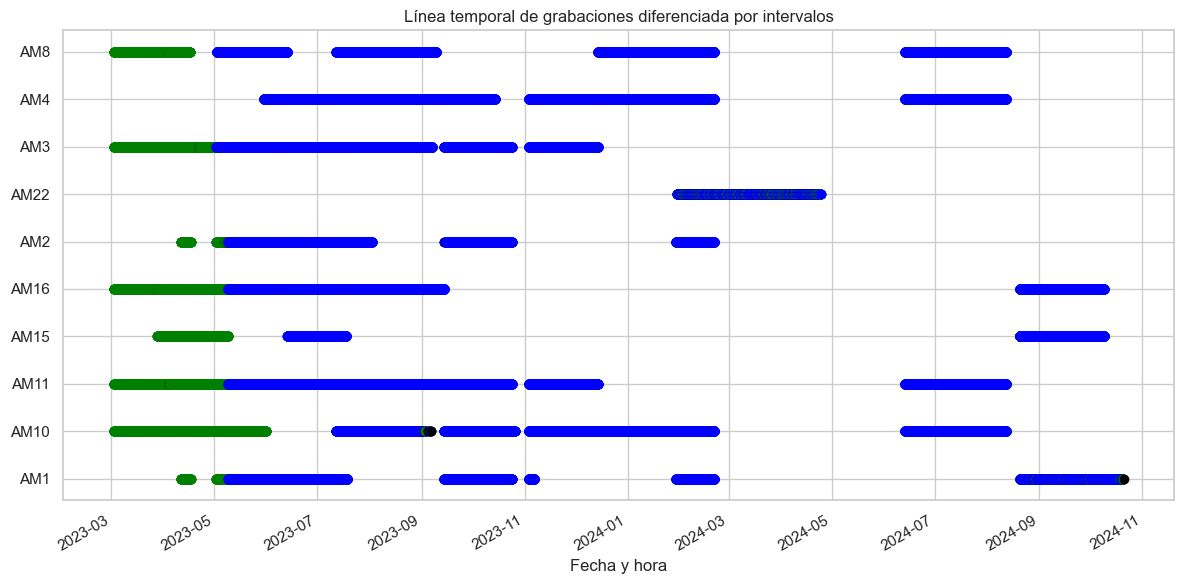

In [12]:
sns.set_theme(style="whitegrid")

# Define el umbral para los gaps (30 minutos)
gap_threshold = timedelta(minutes=30)

fig, ax = plt.subplots(figsize=(12, 6))
recorders = sorted(df['recorder'].unique())

for i, recorder in enumerate(recorders):
    # Obtener grabaciones ordenadas por fecha para esta grabadora
    group = df[df['recorder'] == recorder].sort_values('datetime')
    times = group['datetime'].tolist()
    if not times:
        continue

    # Dividir la secuencia en segmentos donde el gap entre grabaciones sea <= 30 minutos.
    segments = []
    current_segment = [times[0]]
    marker_colors = ['black']  # primer evento del segmento en negro
    for j in range(1, len(times)):
        gap = times[j] - times[j-1]
        if gap <= gap_threshold:
            # Asignar color según el valor del gap:
            if gap < timedelta(minutes=20):
                marker_colors.append('blue')   # intervalos de ~10 minutos
            else:
                marker_colors.append('green')  # intervalos de ~30 minutos
            current_segment.append(times[j])
        else:
            # Gap mayor a 30 minutos: cierra el segmento actual y empieza uno nuevo.
            segments.append((current_segment, marker_colors))
            current_segment = [times[j]]
            marker_colors = ['black']
    if current_segment:
        segments.append((current_segment, marker_colors))

    # Graficar cada segmento:
    for seg, colors in segments:
        # Si el segmento tiene más de un punto, se dibuja una línea que los conecta.
        if len(seg) > 1:
            ax.plot(seg, [i]*len(seg), linestyle='-', color='gray', alpha=0.5)
        # Se grafican los marcadores de cada evento con su color asignado.
        for t, col in zip(seg, colors):
            ax.plot(t, i, marker='o', color=col, markersize=6)

ax.set_yticks(range(len(recorders)))
ax.set_yticklabels(recorders)
ax.set_xlabel("Fecha y hora")
ax.set_title("Línea temporal de grabaciones diferenciada por intervalos")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()